In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
from pyproj import CRS
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
%config Completer.use_jedi = False

# Parcel data

In [3]:
bliska_paczka = pd.read_csv("../datasets/raw_data/bliska_paczka.csv", index_col=0)
bliska_paczka = bliska_paczka.loc[bliska_paczka.available == True, ("brand", "operator", "city", "street", "longitude", "latitude")]
bliska_paczka.brand = bliska_paczka.brand.str.lower()
bliska_paczka.operator = bliska_paczka.operator.str.lower()
bliska_paczka.city = bliska_paczka.city.str.lower()
bliska_paczka.street = bliska_paczka.street.str.lower()
bliska_paczka = bliska_paczka.loc[:, ("brand", "operator", "longitude", "latitude")]

In [4]:
dhl = pd.read_csv("../datasets/raw_data/dhl.csv", index_col=0)
dhl.P_TYPE = dhl.P_TYPE.str.lower() 
dhl = dhl.drop(columns=["ID"])
dhl.columns = ["brand", "latitude", "longitude"]
dhl["operator"] = "dhl"
dhl = dhl[["brand", "operator", "longitude", "latitude"]]

In [5]:
df = pd.concat([bliska_paczka, dhl], axis=0)

In [6]:
display(pd.crosstab(df.brand, df.operator))

operator,dhl,dpd,fedex,inpost,poczta,ruch,ups
brand,,,,,,,
1minute,36,0,0,0,0,0,0
abc,1057,0,0,0,0,0,0
apimarket,22,0,0,0,0,0,0
biedronka_locker,147,0,0,0,0,0,0
dpd,0,3600,0,0,0,0,0
eurosklep,20,0,0,0,0,0,0
groszek,197,0,0,0,0,0,0
inmedio,375,0,0,0,0,0,0
inpost,0,0,0,15317,0,0,0


In [7]:
df = df.drop(columns=["brand"])
df = gpd.GeoDataFrame(df, geometry=[geometry.Point(xy) for xy in zip(df.longitude, df.latitude)], crs=CRS("epsg:4258"))
df = df.drop(columns=["latitude", "longitude"])

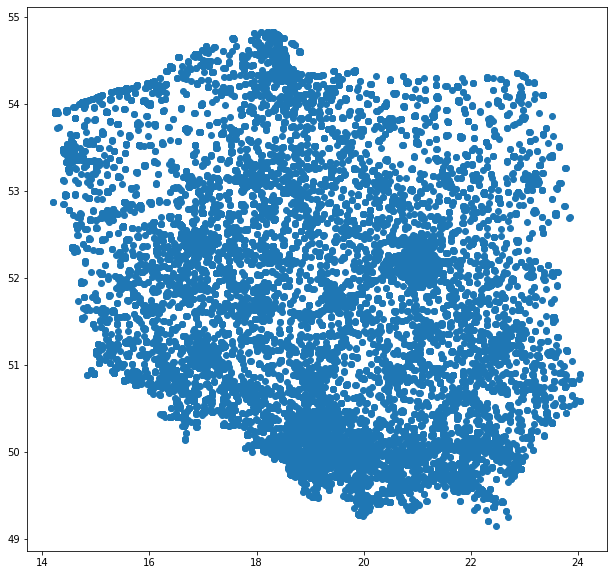

In [8]:
df.plot(figsize=(20,10))
plt.show()

In [9]:
pov = gpd.read_file("../datasets/raw_data/guigk_pov/Powiaty.shx", encoding='utf-8')
pov = pov.loc[pov.JPT_NAZWA_.isin(["powiat Warszawa", "powiat Kraków", "powiat Poznań"])==True, ("JPT_NAZWA_", "geometry")]
pov = pov.to_crs("epsg:4258")

In [10]:
grids = gpd.read_file("../datasets/raw_data/inspire/PD_STAT_GRID_CELL_2011.shp", encoding='utf-8')
grids = grids[['TOT', 'TOT_0_14', 'TOT_15_64', 'TOT_65__', 'TOT_MALE', 'TOT_FEM',
       'MALE_0_14', 'MALE_15_64', 'MALE_65__', 'FEM_0_14', 'FEM_15_64',
       'FEM_65__', 'FEM_RATIO', 'geometry']]
grids = grids.to_crs("epsg:4258")

In [11]:
pov_grids = gpd.sjoin(grids, pov, how="inner", op="within")

In [12]:
# pov_grids[pov_grids.JPT_NAZWA_ == 'powiat Warszawa']

In [13]:
pov_grids.head()

,TOT,TOT_0_14,TOT_15_64,TOT_65__,TOT_MALE,TOT_FEM,MALE_0_14,MALE_15_64,MALE_65__,FEM_0_14,FEM_15_64,FEM_65__,FEM_RATIO,geometry,index_right,JPT_NAZWA_
60321,10,0,8,3,4,6,0,3,0,0,5,3,150.000000,"POLYGON ((16.80856 52.46162, 16.79390 52.46246...",109,powiat Poznań
60393,8,0,6,3,4,4,0,4,0,0,3,3,100.000000,"POLYGON ((16.80718 52.45268, 16.79252 52.45351...",109,powiat Poznań
60732,25,5,18,3,14,11,3,10,0,3,8,0,78.571429,"POLYGON ((16.82183 52.45183, 16.80718 52.45268...",109,powiat Poznań
60762,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,"POLYGON ((16.82321 52.46078, 16.80856 52.46162...",109,powiat Poznań
60871,435,65,319,51,222,213,37,164,21,28,155,30,95.945946,"POLYGON ((16.81768 52.42501, 16.80304 52.42585...",109,powiat Poznań


In [15]:
pov_grids.drop(columns = {'index_right'}, inplace=True)
pov_grids.reset_index(inplace=True)
pov_grids.drop(columns = {'index'}, inplace=True)
pov_grids.reset_index(inplace=True)

In [16]:
def merging_vars(data, poviat, path):
    
    # df for concrete poviat
    df_output = data[data.JPT_NAZWA_ == poviat]
    
    # loading points of interest
    buildings = gpd.read_file(path + 'gis_osm_buildings_a_free_1.shp')
    landuse = gpd.read_file(path + 'gis_osm_landuse_a_free_1.shp')
    pois_a = gpd.read_file(path + 'gis_osm_pois_a_free_1.shp')
    railways = gpd.read_file(path + 'gis_osm_railways_free_1.shp')
    roads = gpd.read_file(path + 'gis_osm_roads_free_1.shp')
    traffic_a = gpd.read_file(path + 'gis_osm_traffic_a_free_1.shp')
    traffic = gpd.read_file(path + 'gis_osm_traffic_free_1.shp')
    transport_a = gpd.read_file(path + 'gis_osm_transport_a_free_1.shp')
    
    # concrete points from above dfs
    buildings_points = buildings[buildings['type'].isin(['house', 'residential', 'bungalow', 'apartment'])][['osm_id', 'geometry']]
    shop_points = buildings[buildings['type'].isin(['supermarket', 'bakery', 'kiosk', 'mall', 'department_store', 'convenience', 'clothes', 'florist', 'chemist'])][['osm_id', 'geometry']]
    parks_points = landuse[landuse['fclass'] == 'park'][['osm_id', 'geometry']]
    forest_points = landuse[landuse['fclass'] == 'forest'][['osm_id', 'geometry']]
    schools_points = pois_a[pois_a['fclass'].isin(['school', 'playground'])][['osm_id', 'geometry']]
    railways_points = railways[['osm_id', 'geometry']]
    cycleways_points = roads[roads['fclass'] == 'cycleway'][['osm_id', 'geometry']]
    parking_points = traffic_a[traffic_a['fclass'] == 'parking'][['osm_id', 'geometry']]
    crossing_points = traffic[traffic['fclass'] == 'crossing'][['osm_id', 'geometry']]
    bus_stop_points = transport_a[transport_a['fclass'] == 'bus_stop'][['osm_id', 'geometry']]
    
    # unnecessery dfs
    del buildings, landuse, pois_a, railways, roads, traffic_a, traffic, transport_a
    
    
    # changing crs
    buildings_points = buildings_points.to_crs("epsg:4258")
    shop_points = shop_points.to_crs("epsg:4258")
    parks_points = parks_points.to_crs("epsg:4258")
    forest_points = forest_points.to_crs("epsg:4258")
    schools_points = schools_points.to_crs("epsg:4258")
    railways_points = railways_points.to_crs("epsg:4258")
    cycleways_points = cycleways_points.to_crs("epsg:4258")
    parking_points = parking_points.to_crs("epsg:4258")
    crossing_points = crossing_points.to_crs("epsg:4258")
    bus_stop_points = bus_stop_points.to_crs("epsg:4258")
    
    # list of dataframes
    list_of_dfs = [buildings_points, shop_points, parks_points, forest_points, schools_points, railways_points,
                  cycleways_points, parking_points, crossing_points, bus_stop_points]
    
    # names of new columns
    names = ['buildings', 'shops', 'parks', 'forests', 'schools', 'railways',
                  'cycleways', 'parkings', 'crossings', 'bus_stops']
    
    # groupby points in a loop
    for i in range(len(list_of_dfs)):
        actual_point = gpd.sjoin(list_of_dfs[i], df_output, how="inner", op="intersects")
        x = actual_point[['osm_id', 'index']].groupby(['index']).count()
        x.rename(columns={"osm_id": names[i]}, inplace=True)
        x.reset_index(inplace = True)
        df_output = df_output.merge(x, on = 'index', how='outer')
        
    df_output.fillna(0, inplace=True)
    df_output.drop(columns = {'JPT_NAZWA_'}, inplace = True)
    df_output.rename(columns={"index": 'grid_id'}, inplace=True)

    
    return df_output

In [ ]:
df_warszawa = merging_vars(df, 'powiat Warszawa', '../../pyk/osm_mazowieckie/')
df_poznan = merging_vars(df, 'powiat Poznań', '../../pyk/osm_wielkopolskie/')
df_krakow = merging_vars(df, 'powiat Kraków', '../../pyk/osm_malopolskie/')

In [ ]:
df_warszawa.to_csv('../datasets/preprocessed_data/df_warszawa.csv', index = False)
df_poznan.to_csv('../datasets/preprocessed_data/df_poznan.csv', index = False)
df_krakow.to_csv('../datasets/preprocessed_data/df_krakow.csv', index = False)